# Modelado Avanzado: SARIMA
Este notebook implementa un modelo SARIMA utilizando el código refactorizado en `src/`.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Import refactored code
from air_traffic.data_processing import load_and_clean_data, aggregate_monthly_passengers

%matplotlib inline


## 1. Carga de Datos

In [2]:
# Define path to data
DATA_PATH = '../Data/Air_Traffic_Passenger_Statistics.csv'

# Load and clean
df = load_and_clean_data(DATA_PATH)
monthly_passengers = aggregate_monthly_passengers(df)

print(f"Data loaded. Shape: {monthly_passengers.shape}")
monthly_passengers.head()


Data loaded. Shape: (129,)


ActivityPeriod
2005-07-01    3225769.0
2005-08-01    3195866.0
2005-09-01    2740553.0
2005-10-01    2770715.0
2005-11-01    2617333.0
Name: PassengerCount, dtype: float64

## 2. División Train/Test

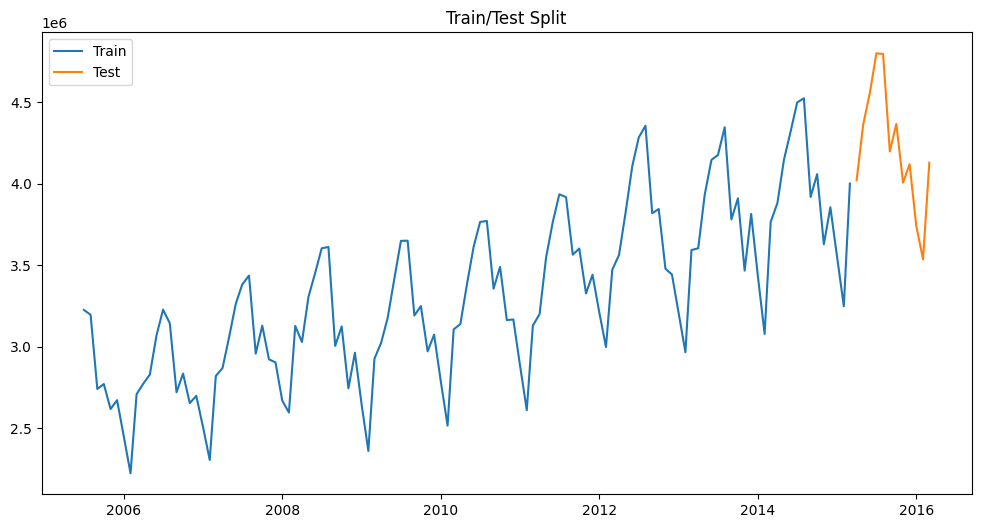

In [3]:
# Split data: Train (all except last 12 months) and Test (last 12 months)
train = monthly_passengers.iloc[:-12]
test = monthly_passengers.iloc[-12:]

plt.figure(figsize=(12, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.title('Train/Test Split')
plt.legend()
plt.show()


## 3. Entrenamiento SARIMA

In [4]:
# SARIMA Model
# We use (1, 1, 1) x (1, 1, 1, 12) based on previous analysis (seasonality 12)
# This is a starting point. In a real scenario, we would perform a grid search.

order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)

model = sm.tsa.statespace.SARIMAX(train,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = model.fit()

print(results.summary())


                                     SARIMAX Results                                      
Dep. Variable:                     PassengerCount   No. Observations:                  117
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1148.087
Date:                            Sat, 29 Nov 2025   AIC                           2306.175
Time:                                    22:20:22   BIC                           2318.674
Sample:                                07-01-2005   HQIC                          2311.215
                                     - 03-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0085      0.307     -0.028      0.978      -0.611       0.594
ma.L1         -0.4189      0.254   

## 4. Diagnóstico

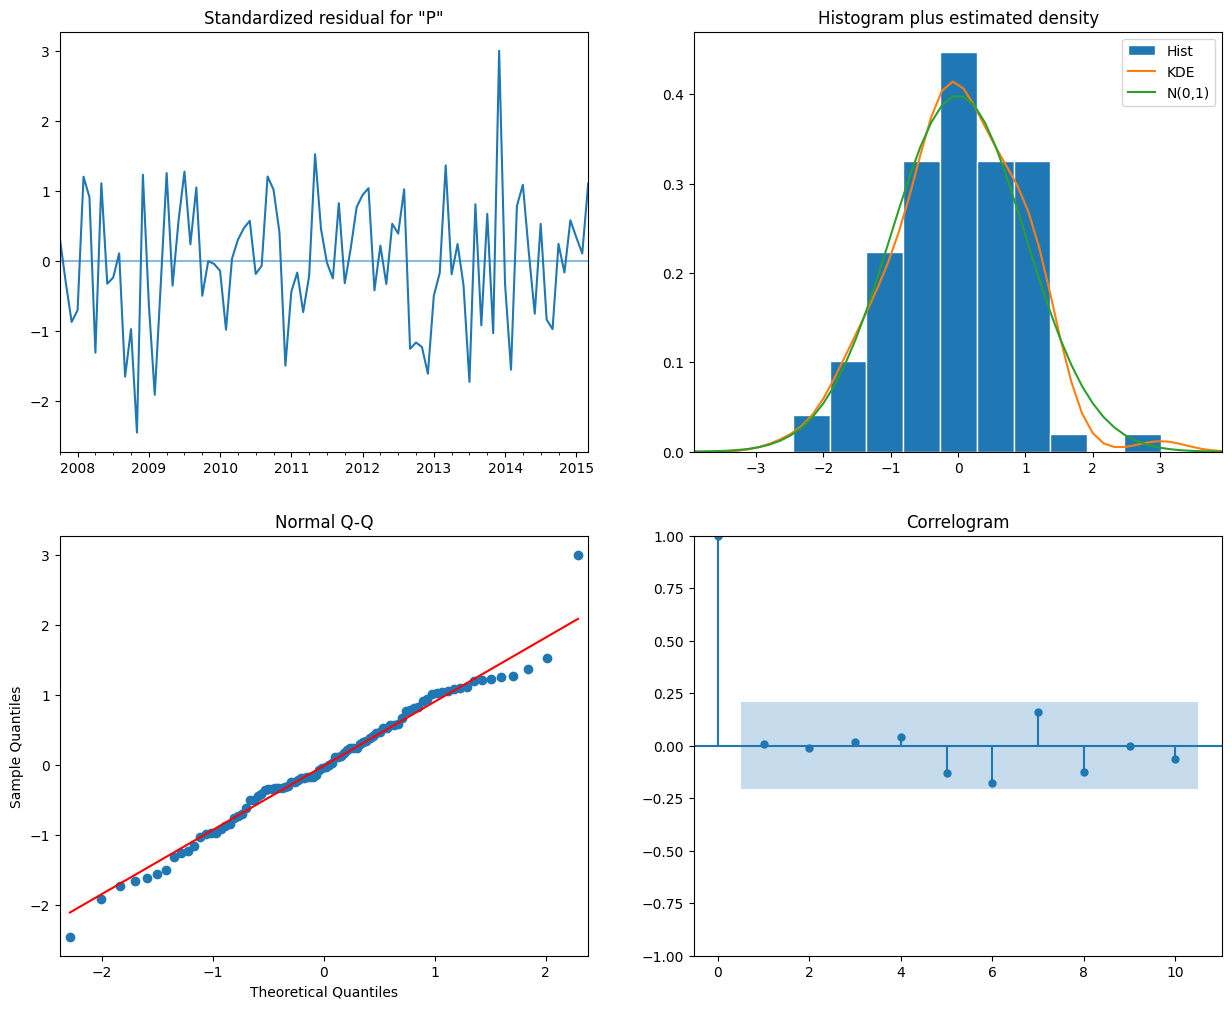

In [5]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()


## 5. Pronóstico y Evaluación

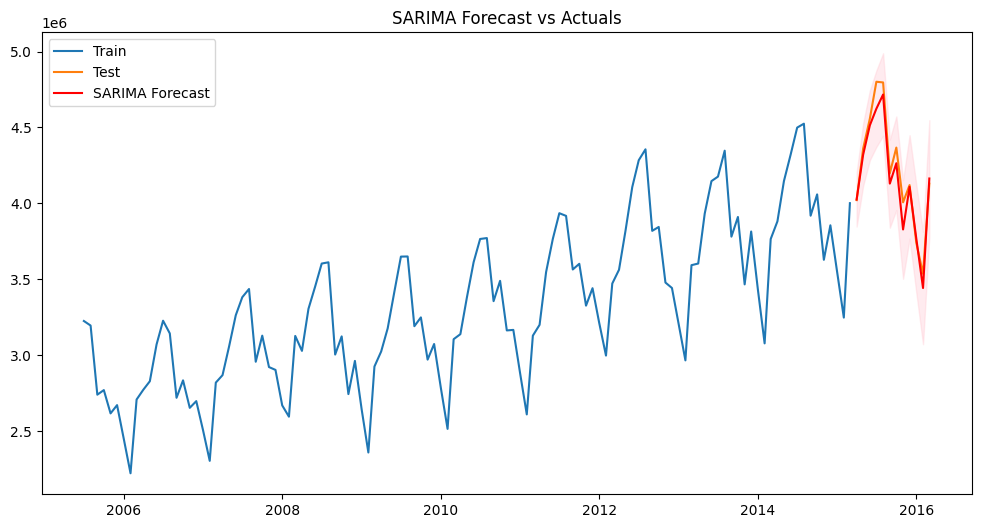

In [6]:
# Forecast
forecast = results.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(forecast_mean.index, forecast_mean, label='SARIMA Forecast', color='red')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('SARIMA Forecast vs Actuals')
plt.legend()
plt.show()


In [7]:
# Metrics
rmse = np.sqrt(mean_squared_error(test, forecast_mean))
mae = mean_absolute_error(test, forecast_mean)
mape = np.mean(np.abs((test - forecast_mean) / test)) * 100

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")


RMSE: 91001.54
MAE: 71880.06
MAPE: 1.69%
